In [1]:
# Library imports (see /Utilities/setup_env.py for full import list and figure setup)

from pathlib import Path
import sys

repo_root = Path.cwd().parents[1]  # .../Figure_analysis
repo_root = repo_root.parent       # repo root
sys.path.insert(0, str(repo_root))

from Figure_analysis.Utilities.setup_env import *

In [26]:
def calc_dG(lnkobs, lnkobs_err, lnkadd, lnkadd_err, temp, ignore_lnkadd_err = False):
    # kobs = K/(K+1)kadd
    # dG = -RT ln(K)

    lnKKp1 = lnkobs - lnkadd
    lnKKp1_err = np.sqrt(lnkobs_err**2 + lnkadd_err**2)

    if ignore_lnkadd_err:
        lnKKp1_err = lnkobs_err

    KKp1 = np.exp(lnKKp1)
    KKp1_err = KKp1 * lnKKp1_err
    K = KKp1 / (1 - KKp1)
    K_err = KKp1_err / (1 - KKp1)**2
    dG = -(sc.R / sc.calorie / 1000) * (temp + 273.15) * np.log(K)
    dG_err = (sc.R / sc.calorie / 1000) * (temp + 273.15) / K * K_err
    dG_err = np.abs(dG_err)

    return dG, dG_err, KKp1, KKp1_err

In [27]:
def safe_frac(invT, dH_fold, Tm, R=1.987e-3, clip_logK=50.0, eps=1e-12):
    """
    invT     : 1/T in K^-1  (your x)
    dH_fold  : kcal/mol
    Tm       : °C (as in your current code)
    R        : kcal/(mol·K)
    """

    invT = np.asarray(invT)

    # Convert Tm to Kelvin
    TmK = Tm + 273.15

    # logK1 = (dH/R) * (1/Tm - 1/T) = (dH/R) * (1/TmK - invT)
    logK1 = (dH_fold / R) * (1.0 / TmK - invT)

    # Clip to avoid huge exponents in the logistic
    logK1 = np.clip(logK1, -clip_logK, clip_logK)

    # Stable logistic: fracf = 1 / (1 + exp(-logK1))
    fracf = 1.0 / (1.0 + np.exp(-logK1))
    fracu = 1.0 - fracf

    # If you ever reintroduce logs, avoid exact 0 or 1
    fracf = np.clip(fracf, eps, 1.0 - eps)
    fracu = np.clip(fracu, eps, 1.0 - eps)

    return fracu, fracf

def melt_fit(x, upper_m, upper_b, lower_m, lower_b, dH_fold, Tm):
    # upper_m: slope of the unfolded state
    # upper_b: y-intercept of the unfolded state
    # lower_m: slope of the folded state
    # lower_b: y-intercept of the folded state
    # dH_fold: energy of the transition state
    # Tm: temperature of the transition state
    
    temp = 1 / x

    R = sc.R / sc.calorie / 1000  # Gas constant in kcal/(mol·K)

    fracu, fracf = safe_frac(x, dH_fold, Tm, R=R)
    basef = lower_m * x + lower_b
    baseu = upper_m * x + upper_b

    final = np.log(fracu) * baseu + np.log(fracf) * basef
    final = fracu * baseu + fracf * basef
    return final

/var/folders/18/qp7ngpw963z9q34k6mzb5jc80000gn/T/ipykernel_85967/614654883.py:15: RuntimeWarning: invalid value encountered in log
  dG = -(sc.R / sc.calorie / 1000) * (temp + 273.15) * np.log(K)
/var/folders/18/qp7ngpw963z9q34k6mzb5jc80000gn/T/ipykernel_85967/614654883.py:15: RuntimeWarning: invalid value encountered in log
  dG = -(sc.R / sc.calorie / 1000) * (temp + 273.15) * np.log(K)
/var/folders/18/qp7ngpw963z9q34k6mzb5jc80000gn/T/ipykernel_85967/614654883.py:15: RuntimeWarning: invalid value encountered in log
  dG = -(sc.R / sc.calorie / 1000) * (temp + 273.15) * np.log(K)
/var/folders/18/qp7ngpw963z9q34k6mzb5jc80000gn/T/ipykernel_85967/614654883.py:15: RuntimeWarning: invalid value encountered in log
  dG = -(sc.R / sc.calorie / 1000) * (temp + 273.15) * np.log(K)
/var/folders/18/qp7ngpw963z9q34k6mzb5jc80000gn/T/ipykernel_85967/614654883.py:15: RuntimeWarning: invalid value encountered in log
  dG = -(sc.R / sc.calorie / 1000) * (temp + 273.15) * np.log(K)
/var/folders/18/qp7n

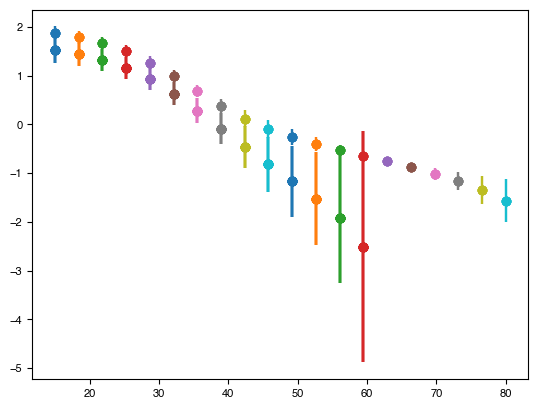

In [28]:
# Calculate kinetic parameters at a given temp

# Make directory to store
os.makedirs('kinetic_params_per_nt', exist_ok=True)

temp_C = 25.0
conc_DMS = 0.015852692  # in M, 1.5% v/v

# Load ln(kadd) Arrhenius fits
lnkadd_A_linfit = load_modelresult('../../Figure2_ProbeKinetics/Add_Arrhenius/Arrhenius_fit_results/agg_4U_A_arrhenius_fit.sav')
lnkadd_C_linfit = load_modelresult('../../Figure2_ProbeKinetics/Add_Arrhenius/Arrhenius_fit_results/agg_4U_C_arrhenius_fit.sav')
lnkadd_linfits = {'A': lnkadd_A_linfit,
                  'C': lnkadd_C_linfit}
to_fit = {'4U_wt': ['7_A', '8_A', '9_C', '15_A', '16_A', '22_A', '25_C', '26_A', '29_A', '34_A', '35_A'],
          '4U_a8c': ['7_A', '8_C', '9_C', '15_A', '16_A', '22_A', '25_C', '26_A', '29_A', '34_A', '35_A']}

# Calculate kinetic parameters at temp_C
rows = []
for construct, sites in to_fit.items():
    for site in sites:

        # Load 2-state fit result
        fit_result = load_modelresult(f'../4U_2stateMelt/2state_fit_results/4U_wt_7_A.sav')
        lnkadd_fit = lnkadd_linfits[site[-1]]

        for temp_C in np.linspace(15, 80, 20):
            # Evaluate ln(kobs) and ln(kadd) at temp_C
            ln_kobs = fit_result.eval(x = 1/(temp_C + 273.15))
            ln_kobs_err = fit_result.eval_uncertainty(x = 1/(temp_C + 273.15))

            # Evaluate ln(kadd) at temp_C
            ln_kadd = lnkadd_fit.eval(x = 1/(temp_C + 273.15)) + np.log(conc_DMS)
            ln_kadd_err = lnkadd_fit.eval_uncertainty(x = 1/(temp_C + 273.15))

            dG, dG_err, KKp1, KKp1_err = calc_dG(ln_kobs, ln_kobs_err, ln_kadd, ln_kadd_err, temp_C)

            plt.errorbar(temp_C, dG, yerr = dG_err, fmt='o')